---
## Step 1: Load The Test Data
In a separate notebook, we will test the model on street sign images pulled from the Interet.  For now, use the provided test data.

In [33]:
# Load pickled data
from matplotlib import pyplot as plt
import numpy as np
import pickle

import tensorflow as tf


#dont forget to run: source activate carnd-term1  if tensorflow doesn't exist

batch_size = 128

testing_file = './test.p'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    

X_test, y_test = test['features'], test['labels']
n_classes = len(np.unique(y_test))


In [34]:

from skimage.transform import resize
import random
from skimage.transform import rotate
import cv2
from skimage.util import random_noise

def gen_data(image):
   imdim = np.shape(image)[0]
   ##generate random size; allow for 25% of image wideth
   newsize = random.randint(imdim,imdim+imdim//4)
   
   image_resized = resize(image, (newsize, newsize, 3),
                          mode='constant',cval=0, 
                          preserve_range=True, clip=True)
   #if newsize < imdim:
   #   image_background = np.random.random_sample((32,32,3))
       
   center = (imdim//2, imdim//2)
   M = cv2.getRotationMatrix2D(center, random.randint(-12,12), 1.0) 
   rotated = cv2.warpAffine(image_resized, M, (imdim, imdim))
   ##edgesize tells us max offset for translation
   edgesize = (newsize-imdim)//2
   
        
   offset = random.randint(-edgesize,edgesize) if edgesize>0 else 0 
   center = newsize//2 + offset
   #print(center, offset)
   sigma = random.uniform(0,.005)
   noisy = random_noise(image_resized, var=sigma*2)  
   outimage = noisy[center-16:center+16, center-16:center+16,:]
   return outimage
   #return outimage

    
#for each class bump us to 10000 samples


def dense_to_one_hot(labels_dense, num_classes):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot



In [35]:
import random
import numpy as np
import cv2
from sklearn.preprocessing import minmax_scale, scale

hist_test, _ = np.histogram(y_test,n_classes)   

def gen_batch(batch_type):
    
    if batch_type == 'test':
        hist = hist_test
        X_data = X_test
        y_data = y_test
        
        

    n_samples = 100000
    #n_labels = 100
    
    clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))

    while True:
      X = np.zeros([batch_size,32,32,3], dtype='float64')
      labels = [random.randint(0,n_classes-1) for i in range(batch_size)]
      #print(labels)
      for indx, label in enumerate(labels):
         ##find the number of exemplars for this label
         n_labels = hist[label]
         label_indices = np.where(y_data==label)[0]
        
         ##source_image will either be returned or used to 
         ##generate a synthetic image
         image_number = label_indices[random.randint(0,n_labels-1)]
       
         lab = cv2.cvtColor(X_data[image_number,:,:,:], cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
         l, a, b = cv2.split(lab)  # split on 3 different channels

         l2 = clahe.apply(l)  # apply CLAHE to the L-channel
 
         lab = cv2.merge((l2,a,b))  # merge channels
         source_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR).astype('float')          
         #source_image = X_data[image_number,:,:,:].astype('float')
  
         shape = source_image.shape
         ##ravel flattens the image
         source_image = minmax_scale(source_image.ravel(), 
                        feature_range=(0,1)).reshape(shape)

         ##decide whether to use the source image or generate a synthetic
         ##using randint.  The more source images you have the less likely
         ##you are to generate an image.  n_samples is the total number of
         ##samples/class desired.  
         #
         if random.randint(0,n_samples) > n_labels:
            X[indx,:,:,:] = gen_data(source_image)
         else:
            X[indx,:,:,:] = source_image
            
         y_one_hot = dense_to_one_hot(np.array(labels), n_classes)
        
      yield X, y_one_hot

In [36]:
test_iterator = gen_batch('test')

restoring model...
INFO:tensorflow:Restoring parameters from ./model_final
Batch Test Accuracy:  0.945312
Batch Test Accuracy:  0.949219
Batch Test Accuracy:  0.984375
Batch Test Accuracy:  0.96875
Batch Test Accuracy:  0.945312
Batch Test Accuracy:  0.957031
Batch Test Accuracy:  0.921875
Batch Test Accuracy:  0.964844
Batch Test Accuracy:  0.941406
Batch Test Accuracy:  0.945312
Batch Test Accuracy:  0.960938
Batch Test Accuracy:  0.953125
Batch Test Accuracy:  0.929688
Batch Test Accuracy:  0.945312
Batch Test Accuracy:  0.964844
Batch Test Accuracy:  0.941406
Batch Test Accuracy:  0.957031
Batch Test Accuracy:  0.949219
Batch Test Accuracy:  0.953125
Batch Test Accuracy:  0.957031
Batch Test Accuracy:  0.972656
Batch Test Accuracy:  0.96875
Batch Test Accuracy:  0.964844
Batch Test Accuracy:  0.949219
Batch Test Accuracy:  0.945312
Batch Test Accuracy:  0.960938
Batch Test Accuracy:  0.96875
Batch Test Accuracy:  0.976562
Batch Test Accuracy:  0.96875
Batch Test Accuracy:  0.960938

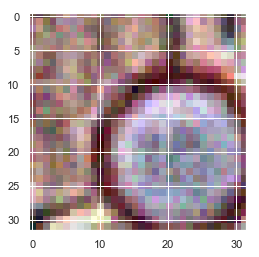

In [53]:
print("restoring model...")

from sklearn.metrics import confusion_matrix
import tensorflow as tf

batch_size = 256
n_test_batches = 50

test_accuracy, class_preds, yvals = [],[],[]

tf.reset_default_graph()

graph = tf.get_default_graph()
#init = tf.global_variables_initializer()
saver = tf.train.import_meta_graph('./model_final.meta') 

#x = graph.get_tensor_by_name("x:0")

with tf.Session() as sess:
    #sess.run(init)

    saver.restore(sess,tf.train.latest_checkpoint('./'))



    #na = return_activation(c1, testvec)
    #print(np.shape(na))
 
    cpred = graph.get_tensor_by_name("correct_pred:0")

    for batch in range(n_test_batches):
       batch_x, batch_y = next(test_iterator) 
 
  
       preds = sess.run(cpred, feed_dict = {"x:0": batch_x, 
                                            "y:0": batch_y,
                                            "keep_prob:0": 1.0})
 
       accuracy = graph.get_tensor_by_name("accuracy:0")    
       
       test_acc = sess.run(accuracy,
                           feed_dict={"x:0": batch_x, 
                                      "y:0": batch_y,
                                      "keep_prob:0": 1.})
       test_accuracy.append(test_acc)
    
       print('Batch Test Accuracy: ', test_acc)
       
       prob_vec = graph.get_tensor_by_name("prob_vec:0")
       pvec = sess.run(prob_vec, 
                       feed_dict={"x:0": batch_x, 
                                  "y:0": batch_y,
                                  "keep_prob:0": 1.})
    
       class_preds.append(np.argmax(pvec, axis=1).tolist())
       correct_prediction = sess.run(cpred, 
                                     feed_dict={"x:0": batch_x, 
                                                "y:0": batch_y,
                                                "keep_prob:0": 1.})
       
       yvals.append([onehot.index(1) for onehot in batch_y.tolist()])


    print("Average test accuracy: ",np.mean(test_accuracy))
 
#import seaborn as sns; sns.set()
flattened_yvals = sum(yvals,[])
flattened_class_preds = sum(class_preds, [])

cm = confusion_matrix(flattened_yvals, flattened_class_preds)
#print(cm)

#ax = sns.heatmap(cm)

## Output a confusion matrix and identify worst offenders

[[281   0   0 ...,   0   0   0]
 [  0 300   0 ...,   0   0   0]
 [  0   1 282 ...,   0   0   0]
 ..., 
 [  0   3   0 ..., 272   0   0]
 [  0   0   0 ...,   0 328   0]
 [  0   1   1 ...,   0  18 266]]


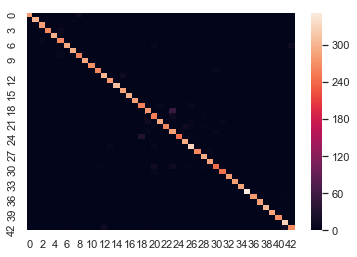

*****LABEL: 0 ******
worst confusor for  0 : 8
label error rate:  0.0506756756757
*****LABEL: 1 ******
worst confusor for  1 : 7
label error rate:  0.0196078431373
*****LABEL: 2 ******
worst confusor for  2 : 5
label error rate:  0.013986013986
*****LABEL: 3 ******
worst confusor for  3 : 5
label error rate:  0.05
*****LABEL: 4 ******
worst confusor for  4 : 1
label error rate:  0.013201320132
*****LABEL: 5 ******
worst confusor for  5 : 2
label error rate:  0.0537634408602
*****LABEL: 6 ******
worst confusor for  6 : 42
label error rate:  0.0869565217391
*****LABEL: 7 ******
worst confusor for  7 : 8
label error rate:  0.0358306188925
*****LABEL: 8 ******
worst confusor for  8 : 5
label error rate:  0.0747330960854
*****LABEL: 9 ******
worst confusor for  9 : 10
label error rate:  0.0201342281879
*****LABEL: 10 ******
worst confusor for  10 : 31
label error rate:  0.0109090909091
*****LABEL: 11 ******
worst confusor for  11 : 30
label error rate:  0.0501792114695
*****LABEL: 12 ******

In [51]:
import seaborn as sns; sns.set()
flattened_yvals = sum(yvals,[])
flattened_class_preds = sum(class_preds, [])

cm = confusion_matrix(flattened_yvals, flattened_class_preds)
print(cm)
ax = sns.heatmap(cm)
plt.show()

for val in range(len(cm[0])):
    sort_indices = np.argsort(cm[val,:])
    nmissed = np.sum(cm[val,:])-cm[val,val]
    if nmissed != 0:
      ##print labels with confusors
      print("*****LABEL:", val, "******")    
      #print(val,cm[val,:])
      print("worst confusor for ", val, ":", sort_indices[-2])
      print("label error rate: ", nmissed/np.sum(cm[val,:]))
            
            